In [1]:
import pandas as pd
%matplotlib inline

In [2]:
movie_plots_data = pd.read_csv('wiki_movie_plots_deduped.csv')

# 1. Topic Modeling

In [4]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

## 1.1. Select data subset: films newer than 2015 and of "comedy" genre

In [5]:
movie_plots_selection = movie_plots_data[(movie_plots_data['Release Year'] > 2015) & movie_plots_data['Genre'].str.contains('comedy')]

In [6]:
movie_plots = movie_plots_selection.Plot
movie_plots.head()

17030    The film starts in Miami on the boat of crime ...
17032    Norm the polar bear is the son of the king of ...
17033    Jason Kelly is a lawyer who works for his fath...
17038    In the spirit realm, Oogway fights against an ...
17041    In 1951, Eddie Mannix (Josh Brolin) is the hea...
Name: Plot, dtype: object

## 1.2. Extract Entities

In [9]:
txt = movie_plots[movie_plots.index[0]][0:1000]

In [10]:
doc = nlp(txt)

In [11]:
print('INPUT:', txt)

INPUT: The film starts in Miami on the boat of crime lord Antonio Pope. His hacker A.J. is going through a list on the computer. Pope calls Port Commissioner Griffin on the phone and accuses him of stealing money from him. With one of his hitmen in the room, Pope has Griffin killed in his apartment, then orders his hitmen to find whoever left with his money.
Meanwhile in Atlanta, James is with his partner Detective Mayfield as they go to infiltrate a vehicle meet to find an infamous drug dealer named Troy. Ben, fresh out the academy, is eager to get in on the action, but James has him staying on the radio. James gets close enough to Troy, but Troy pulls a gun on him. Ben sees this over the camera and sneaks out to help. He rides into the meet in a showy car with hydraulics and draws unwanted attention to himself. He threatens Troy by acting tough dancing only to drop his badge in front of the crook. Then within seconds a brief shootout occurs leading to a random plan "B" with Mayfield 

In [12]:
print('OUTPUT:', [(x.text, x.label_) for x in doc.ents])

OUTPUT: [('Miami', 'GPE'), ('Antonio Pope', 'PERSON'), ('A.J.', 'PERSON'), ('Pope', 'PERSON'), ('Port', 'PRODUCT'), ('Griffin', 'PERSON'), ('one', 'CARDINAL'), ('Pope', 'PERSON'), ('Griffin', 'PERSON'), ('Atlanta', 'GPE'), ('James', 'PERSON'), ('Detective Mayfield', 'PERSON'), ('Troy', 'PERSON'), ('Ben', 'PERSON'), ('James', 'PERSON'), ('James', 'PERSON'), ('Troy', 'PERSON'), ('Troy', 'PERSON'), ('Ben', 'PERSON'), ('Troy', 'PERSON'), ('seconds', 'TIME'), ('Mayfield gettin', 'PERSON')]


## 1.3. Entities Visualization

In [13]:
displacy.render(doc, style='ent', jupyter=True)

## 1.4. Extract Dependencies

In [14]:
def filter_spans(spans):
    sorted_spans = spacy.util.filter_spans(spans)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end-1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result

In [18]:
def extract_entity_relations(doc, relation_types):
    spans = list(doc.ents) + list(doc.noun_chunks)
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            retokenizer.merge(span)
    
    relations = []
    for relation_type in relation_types:
        for entity in filter(lambda w: w.ent_type_ == relation_type, doc):
            if entity.dep_ in ('attr', 'dobj'):
                subject = [w for w in entity.head.lefts if w.dep_ == 'nsubj']
                if subject:
                    subject = subject[0]
                    relations.append((subject, entity))
                elif entity.dep_ == 'pobj' and entity.head.dep_ == 'prep':
                    relations.append(entity.head.dep_, entity)
    return relations

In [19]:
relations = extract_entity_relations(doc, ['PERSON'])

In [20]:
if relations:
    for r1, r2 in relations:
        print("{:<10} -> {} ({})".format(r1.text, r2.text, r2.ent_type_))

Pope       -> Port Commissioner Griffin (PERSON)
He         -> Troy (PERSON)


In [21]:
relations_dict = {"noun_phrase": [], "entity": [], "entity_type": []}

In [25]:
relations_dict = {'noun_phrase': [], 'entity': [], 'entity_type': []}
for plot in movie_plots:
    doc = nlp(plot)
    relations = extract_entity_relations(doc, ['PERSON', 'GPE'])
    if relations:
        for r1, r2 in relations:
            relations_dict['noun_phrase'].append(r1.text)
            relations_dict['entity'].append(r2.text)
            relations_dict['entity_type'].append(r2.ent_type_)

In [26]:
relations_df = pd.DataFrame.from_dict(relations_dict)

In [27]:
relations_df.head()

,noun_phrase,entity,entity_type
0,Pope,Port Commissioner Griffin,PERSON
1,He,Troy,PERSON
2,James,Troy,PERSON
3,James,Troy,PERSON
4,James,Ben,PERSON


## 1.5. Most Popular Subjects

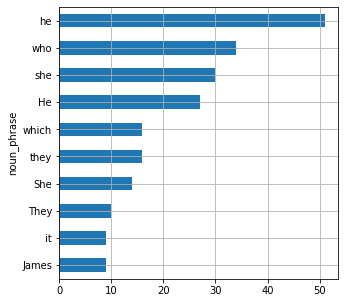

In [29]:
relations_df.groupby(['noun_phrase']).size().sort_values(ascending=True).tail(10).plot(kind='barh', figsize=(5,5), grid=True)

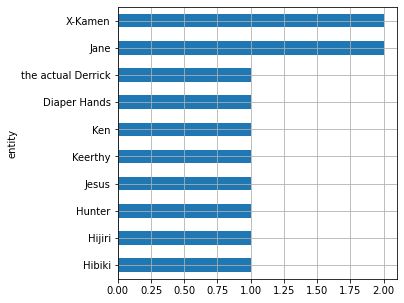

In [30]:
relations_df[relations_df['noun_phrase']=='he'].groupby(['entity']).size().sort_values(ascending=True).tail(10).plot(kind='barh', figsize=(5,5), grid=True)

## 1.6. Most Popular Subjects

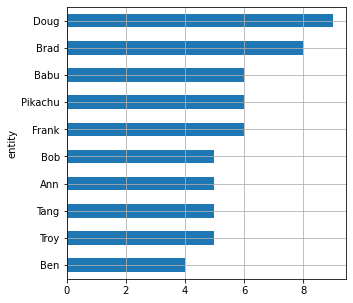

In [31]:
relations_df.groupby(['entity']).size().sort_values(ascending=True).tail(10).plot(kind='barh', figsize=(5,5), grid=True)

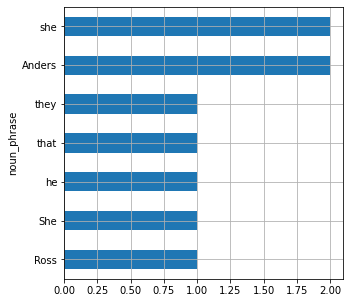

In [32]:
relations_df[relations_df.entity=='Doug'].groupby(['noun_phrase']).size().sort_values(ascending=True).tail(10).plot(kind='barh', figsize=(5,5), grid=True)